C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


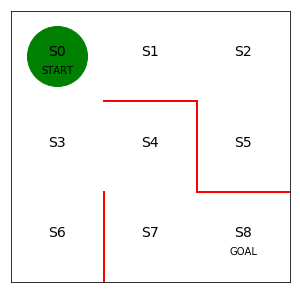

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.plot([1,1],[0,1],color='red', linewidth=2)
plt.plot([1,2],[2,2],color='red', linewidth=2)
plt.plot([2,2],[2,1],color='red', linewidth=2)
plt.plot([2,3],[1,1],color='red', linewidth=2)

plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)

plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off',right='off', left='off', labelleft='off')

line, = ax.plot([0.5], [2.5], marker="o",color='g', markersize=60)



In [2]:
theta_0 = np.array([[np.nan, 1, 1, np.nan], #S0
                    [np.nan, 1, np.nan, 1], #S1
                    [np.nan, np.nan, 1, 1], #S2
                    [1, 1, 1, np.nan], #S3
                    [np.nan, np.nan, 1, 1], #S4
                    [1, np.nan, np.nan, np.nan], #S5
                    [1, np.nan, np.nan, np.nan], #S6
                    [1, 1, np.nan, np.nan], #S7
                   ])

def softmax_convert_into_pi_from_theta(theta):
    
    beta= 1.0
    [m, n] = theta.shape
    #print([m, n])
    pi = np.zeros((m, n))
    #print(pi)
    exp_theta = np.exp(beta*theta)
    #print(exp_theta)
    for i in range(0, m):
        pi[i, :] = exp_theta[i, :]/np.nansum(exp_theta[i, :])
        
    pi = np.nan_to_num(pi)
    
    return pi
        
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
pi_0
#exp_theta = np.exp(theta_0)
#exp_theta

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [3]:
def get_action_and_next_s(pi, s):
    """状態関数pi, 現在地s（整数=0,1,2,・・・,7）"""
    direction = ["up", "right", "down", "left"]
    
    next_direction = np.random.choice(direction, p=pi[s,:])
    
    if next_direction =="up":
        s_next = s-3
        action = 0
    elif next_direction =="right":
        s_next = s+1
        action = 1
    elif next_direction =="down":
        s_next = s+3
        action = 2
    elif next_direction =="left":
        s_next = s-1
        action = 3

    return [action, s_next]

get_action_and_next_s(pi_0, 1)

[3, 0]

In [4]:
def goal_maze_ret_s_a(pi):
    
    s=0
    s_a_history =[[0, np.nan]]
    
    while(1):
        [action, next_s] = get_action_and_next_s(pi_0, s)
        s_a_history[-1][1] = action
        s_a_history.append([next_s, np.nan] )
        
        if next_s==8:
            break
        else:
            s=next_s
            
    return s_a_history

history = goal_maze_ret_s_a(pi_0)
#history


In [5]:
def update_theta(theta, pi, s_a_history):
    
    #print(theta)
    
    eta = 0.05
    T = len(s_a_history) -1
    
    [m,n] = theta.shape
    delta_theta = theta.copy()
    
    for i in range(0, m):
        for j in range(0,n):
            if not(np.isnan(theta[i,j])):
                #print("[i, j] = [{0}, {1}]".format(i,j))
                SA_i = [SA for SA in history if SA[0]==i]
                #print(SA_i)
                SA_ij = [SA for SA in history if SA==[i,j] ]
                #print(SA_ij)
                
                N_i = len(SA_i)
                #print(N_i)
                N_ij = len(SA_ij)
                #print(N_ij)
                
                delta_theta[i, j] = (N_ij - pi[i,j]*N_i)/T
                #print("")
    
    #print(delta_theta)
    new_theta = theta + eta*delta_theta
    #print(new_theta)
    return new_theta
    

In [6]:
stop_epsilon = 10**(-3)

theta = theta_0
pi = pi_0
step = 100

is_continue = True
count = 1

while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)
    new_step = len(s_a_history)-1
    if new_step > step:
        continue
    
    new_theta = update_theta(theta, pi, s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    delta_pi = np.sum(np.abs(new_pi - pi))
    print(delta_pi)
    print("step : {0}".format(step))
    
    if delta_pi < stop_epsilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi
        step = new_step


print(theta)
print(pi)

0.010321211601158453
step : 100
0.023965697300276922
step : 14
0.023664564178931757
step : 6
0.023364303089089933
step : 6
0.02306519409637131
step : 6
0.022767497730468267
step : 6
0.03371515179729184
step : 6
0.033049934810806314
step : 4
0.0323922777998602
step : 4
0.0317430776303107
step : 4
0.03110311115985792
step : 4
0.03047304367837672
step : 4
0.02985343731958018
step : 4
0.029244759334708215
step : 4
0.028647390140340456
step : 4
0.0280616310716299
step : 4
0.027487711789272506
step : 4
0.026925797303250787
step : 4
0.02637599458907469
step : 4
0.025838358782873105
step : 4
0.025312898950551332
step : 4
0.024799583433438688
step : 4
0.02429834477856674
step : 4
0.023809084266228686
step : 4
0.02333167605080072
step : 4
0.022865970933267032
step : 4
0.022411799785508002
step : 4
0.02196897664741504
step : 4
0.021537301518331553
step : 4
0.02111656286436131
step : 4
0.020706539862739515
step : 4
0.02030700440391292
step : 4
0.019917722871190147
step : 4
0.019538457716896773
ste

0.0017779983501449714
step : 4
0.0017675681759904416
step : 4
0.0017572273845053998
step : 4
0.001746974972058002
step : 4
0.001736809948860163
step : 4
0.001726731338738019
step : 4
0.001716738178910271
step : 4
0.0017068295197687489
step : 4
0.0016970044246669702
step : 4
0.0016872619697083646
step : 4
0.001677601243539939
step : 4
0.0016680213471520489
step : 4
0.0016585213936797238
step : 4
0.0016491005082078236
step : 4
0.001639757827580579
step : 4
0.0016304925002134651
step : 4
0.0016213036859142327
step : 4
0.0016121905556933935
step : 4
0.0016031522915986307
step : 4
0.0015941880865326663
step : 4
0.0015852971440863395
step : 4
0.0015764786783715734
step : 4
0.001567731913856396
step : 4
0.0015590560852028479
step : 4
0.001550450437110662
step : 4
0.0015419142241628325
step : 4
0.001533446710667019
step : 4
0.0015250471705134938
step : 4
0.001516714887022208
step : 4
0.0015084491528032373
step : 4
0.0015002492696076786
step : 4
0.0014921145481973652
step : 4
0.0014840443081999

In [10]:
from matplotlib import animation
from IPython.display import HTML

def init():
    
    line.set_data([], [])
    return (line,)


def animate(i):
    
    state = s_a_history[i][0]
    x = (state%3) + 0.5
    y = 2.5 - int(state/3)
    line.set_data(x, y)

    return(line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())